## Homework 02-2: due 2022/03/31 23:59 (70%)

### - Tutorial : https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a regression model in this part. The data is **Concrete Compressive Strength Dataset**, you can find the details of each column at https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength. In this part, please predict the **strength of concrete**.

In [1]:
# Import necessory modules
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

In [2]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (10%)

#### 1.1 Please follow the tutorial to create a class ***ConcreteDataset***, for loading the data you need and also do the ***Min-Max scaling*** to the ***feature and label***. (5%)

In [3]:
class ConcreteDataset(Dataset):
    #load the dataset
    def __init__(self, path):
        # load csv file
        df = pd.read_csv(path)
        #define the minmax scaling
        self.scaler = MinMaxScaler()
        #store the inputs and outputs
        self.X = df.values[:,:-1] #input variables 
        self.Y = df.values[:,-1]  #output variables
        #scale input and turn it into float
        self.X = self.scaler.fit_transform(self.X)
        self.X = self.X.astype('float32')
        #label encode target
        self.Y = self.scaler.fit_transform(self.Y.reshape(-1,1))
        self.Y = self.Y.astype('float32')
        
    # number of rows in the dataset    
    def __len__(self):
        return len(self.X)
    
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

#### 1.2 By following the tutorial, try to create a class ***MLP(Neural Network)*** with ***three hidden layers*** as your network architecture. Also, for the convenience of implementation, please set the numbers of hidden nodes and the activation functions as input variables to the foward functions.(5%) 

In [4]:
class MLP(nn.Module):
    #define model elements
    def __init__(self, n_inputs, hiddenlayer1, hiddenlayer2, hiddenlayer3, node_act, out_act): #model parameters
        super(MLP, self).__init__()
        # input
        self.input = nn.Linear(n_inputs, hiddenlayer1)
        self.act1 = node_act
        #first hidden layer
        self.hidden1 = nn.Linear(hiddenlayer1, hiddenlayer2)
        nn.init.xavier_uniform_(self.hidden1.weight)
        self.act2 = node_act
        # second hidden layer
        self.hidden2 = nn.Linear(hiddenlayer2, hiddenlayer3)
        nn.init.xavier_uniform_(self.hidden2.weight)
        self.act3 = node_act
        # third hidden layer and output
        self.hidden3 = nn.Linear(hiddenlayer3, 1)
        nn.init.xavier_uniform_(self.hidden3.weight)
        self.output = out_act
        
    def forward(self, X):
        # input to first hidden layer
        X = self.input(X)
        X = self.act1(X)
        X = self.hidden1(X)
        X = self.act2(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act3(X)
        # output layer
        X = self.hidden3(X)
        X = self.output(X)
        return X

print(MLP(8, 256, 64, 8, nn.Tanh(), nn.Tanh()))

MLP(
  (input): Linear(in_features=8, out_features=256, bias=True)
  (act1): Tanh()
  (hidden1): Linear(in_features=256, out_features=64, bias=True)
  (act2): Tanh()
  (hidden2): Linear(in_features=64, out_features=8, bias=True)
  (act3): Tanh()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (output): Tanh()
)


### 2. Train the model (60%)

#### 2.1 Please load the ***train.csv/ validation.csv*** in ./data, and turn them into dataloader with batch size 64 and determine whether shuffle or not. (5%)

In [5]:
# load the dataset
# train dataloader
path = "./data/train.csv"
train = ConcreteDataset(path)
train_dl = DataLoader(train, batch_size=64, shuffle=True)

# validation dataloader
path = "./data/validation.csv"
validation = ConcreteDataset(path)
validation_dl = DataLoader(validation, batch_size=64, shuffle=False)

#### 2.2 Create two MLP model from the table below and ***print the model*** (10%):
| | Hidden Layer 1| Hidden Layer 2| Hidden Layer 3| Activation in each hidden nodes | Activation for output |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Model1***| 256 | 64 | 8 | Tanh | Tanh |
|***Model2***| 64 | 16 | 8 | Tanh | Identity |

In [6]:
# define the model
# model 1
model1 = MLP(8, 256, 64, 8, nn.Tanh(), nn.Tanh()) #inputs are 8 features
# model 2
model2 = MLP(8, 64, 16, 8, nn.Tanh(), nn.Identity())

models = {"Model1":model1,"Model2":model2} #create a dictionary for two models

for name, values in  models.items():
    print (name, values)

Model1 MLP(
  (input): Linear(in_features=8, out_features=256, bias=True)
  (act1): Tanh()
  (hidden1): Linear(in_features=256, out_features=64, bias=True)
  (act2): Tanh()
  (hidden2): Linear(in_features=64, out_features=8, bias=True)
  (act3): Tanh()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (output): Tanh()
)
Model2 MLP(
  (input): Linear(in_features=8, out_features=64, bias=True)
  (act1): Tanh()
  (hidden1): Linear(in_features=64, out_features=16, bias=True)
  (act2): Tanh()
  (hidden2): Linear(in_features=16, out_features=8, bias=True)
  (act3): Tanh()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (output): Identity()
)


#### 2.3 Train the above two models with the same hyperpameters below and do the validation in every epoch. Choose the appropriate type of loss function according to the task. (25%)
##### (Note. You should record the training/validation loss every epoch)


| | Learning rate | epochs | optimizer | momentum |
|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 0.01 | 300 | SGD | 0.9 |

In [7]:
# train the model
def train_model(models, num_epoch):
    # define the optimization
    criterion = nn.MSELoss()
    loss_epoch = {} #save the train and validation loss of two models
    
    for name, values in models.items():
        loss_epoch[name] = {"Training Loss":[],"Validation Loss":[]}
        optimizer = optim.SGD(models[name].parameters(), lr=0.01, momentum=0.9)
    
        # enumerate epochs
        for epoch in range(num_epoch):
            train_loss_list = [] #every batch
            val_loss_list = []
        # enumerate mini batches
            #train_loss = 0.0
            for inputs, labels in train_dl:
                # clear the gradients
                optimizer.zero_grad()
                # forward pass
                yhat = values(inputs)
                # calculate loss
                loss = criterion(yhat, labels)
                # credit assignment
                loss.backward()
                # update model weights
                optimizer.step()
                train_loss = loss.item()
                train_loss_list.append(train_loss)#mean of batch value
            
            #valid_loss = 0.0
            for inputs, labels in validation_dl:
                yhat = values(inputs)
                loss = criterion(yhat, labels)
                valid_loss = loss.item() 
                val_loss_list.append(valid_loss)
            print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_dl)} \t\t Validation Loss: {valid_loss / len(validation_dl)}')
            
            loss_epoch[name]["Training Loss"].append(sum(train_loss_list)/len(train_loss_list)) # in order to plot
            loss_epoch[name]["Validation Loss"].append(sum(val_loss_list)/len(val_loss_list))
            
            
            FILE = f"{name}.pth"
            torch.save(values.state_dict(), FILE)
        
        #plot 
        plt.plot(loss_epoch[name]["Training Loss"], 'b', label='Training Loss')
        plt.plot(loss_epoch[name]["Validation Loss"], 'orange', label='Validation Loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    return loss_epoch

Epoch 1 		 Training Loss: 0.005245344570049873 		 Validation Loss: 0.022921748459339142
Epoch 2 		 Training Loss: 0.0027172147081448482 		 Validation Loss: 0.009420146234333515
Epoch 3 		 Training Loss: 0.0018945369296349012 		 Validation Loss: 0.007818561047315598
Epoch 4 		 Training Loss: 0.00128488873059933 		 Validation Loss: 0.009228180162608624
Epoch 5 		 Training Loss: 0.001327759657914822 		 Validation Loss: 0.007600742857903242
Epoch 6 		 Training Loss: 0.0010794666953957998 		 Validation Loss: 0.009171308018267155
Epoch 7 		 Training Loss: 0.001438165083527565 		 Validation Loss: 0.007337109185755253
Epoch 8 		 Training Loss: 0.0013330769366942919 		 Validation Loss: 0.009057968854904175
Epoch 9 		 Training Loss: 0.0012813941217385805 		 Validation Loss: 0.008745240978896618
Epoch 10 		 Training Loss: 0.0010686200828506397 		 Validation Loss: 0.007290144916623831
Epoch 11 		 Training Loss: 0.0012395581087240805 		 Validation Loss: 0.009386859834194183
Epoch 12 		 Training Los

Epoch 98 		 Training Loss: 0.0008455515624238894 		 Validation Loss: 0.010743140242993832
Epoch 99 		 Training Loss: 0.0007932461941471467 		 Validation Loss: 0.007020127959549427
Epoch 100 		 Training Loss: 0.000630768732382701 		 Validation Loss: 0.011375789530575275
Epoch 101 		 Training Loss: 0.0005635710146564704 		 Validation Loss: 0.007724159862846136
Epoch 102 		 Training Loss: 0.0008471090203294387 		 Validation Loss: 0.00967852771282196
Epoch 103 		 Training Loss: 0.0005468856901503527 		 Validation Loss: 0.008221983909606934
Epoch 104 		 Training Loss: 0.000921247240442496 		 Validation Loss: 0.011355165392160416
Epoch 105 		 Training Loss: 0.0009721658694056364 		 Validation Loss: 0.0096924202516675
Epoch 106 		 Training Loss: 0.0009374505338760522 		 Validation Loss: 0.008517486043274403
Epoch 107 		 Training Loss: 0.0005181272012683061 		 Validation Loss: 0.008993828669190407
Epoch 108 		 Training Loss: 0.0009847981855273247 		 Validation Loss: 0.010233849287033081
Epoch 

Epoch 196 		 Training Loss: 0.0005110109654756692 		 Validation Loss: 0.009734151884913445
Epoch 197 		 Training Loss: 0.0008386824853145159 		 Validation Loss: 0.011193341575562954
Epoch 198 		 Training Loss: 0.0009089216160086485 		 Validation Loss: 0.0108335567638278
Epoch 199 		 Training Loss: 0.0006095426730238474 		 Validation Loss: 0.007942009717226028
Epoch 200 		 Training Loss: 0.0007366909860418393 		 Validation Loss: 0.009818721562623978
Epoch 201 		 Training Loss: 0.0003883483318182138 		 Validation Loss: 0.008545804768800735
Epoch 202 		 Training Loss: 0.0009354110807180405 		 Validation Loss: 0.009965966455638409
Epoch 203 		 Training Loss: 0.0004380887302641685 		 Validation Loss: 0.010065259411931038
Epoch 204 		 Training Loss: 0.0006533553107426717 		 Validation Loss: 0.014367234893143177
Epoch 205 		 Training Loss: 0.000707156597994841 		 Validation Loss: 0.007040238473564386
Epoch 206 		 Training Loss: 0.0006932864108910927 		 Validation Loss: 0.01557876542210579
Epo

Epoch 297 		 Training Loss: 0.000528731240102878 		 Validation Loss: 0.013462202623486519
Epoch 298 		 Training Loss: 0.0004370536010425824 		 Validation Loss: 0.011306101456284523
Epoch 299 		 Training Loss: 0.0010459238233474584 		 Validation Loss: 0.010603072121739388
Epoch 300 		 Training Loss: 0.0008544144578851187 		 Validation Loss: 0.01650220900774002


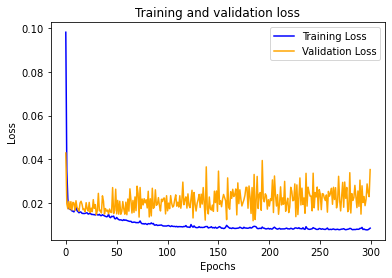

Epoch 1 		 Training Loss: 0.005021275236056401 		 Validation Loss: 0.0419970341026783
Epoch 2 		 Training Loss: 0.0023630444820110616 		 Validation Loss: 0.015013225376605988
Epoch 3 		 Training Loss: 0.0019366324234467286 		 Validation Loss: 0.012307104654610157
Epoch 4 		 Training Loss: 0.0018225575868900006 		 Validation Loss: 0.010934354737401009
Epoch 5 		 Training Loss: 0.0018560499525987185 		 Validation Loss: 0.008608397096395493
Epoch 6 		 Training Loss: 0.0013349468891437238 		 Validation Loss: 0.007801686879247427
Epoch 7 		 Training Loss: 0.0013386657318243613 		 Validation Loss: 0.007516039535403252
Epoch 8 		 Training Loss: 0.0012931448335830981 		 Validation Loss: 0.007254579104483128
Epoch 9 		 Training Loss: 0.0012242259600987802 		 Validation Loss: 0.0074425265192985535
Epoch 10 		 Training Loss: 0.0011523067951202393 		 Validation Loss: 0.009153959341347218
Epoch 11 		 Training Loss: 0.0011763258192401666 		 Validation Loss: 0.009466726332902908
Epoch 12 		 Training 

Epoch 93 		 Training Loss: 0.0007997492614846963 		 Validation Loss: 0.005658530630171299
Epoch 94 		 Training Loss: 0.0008502889854403642 		 Validation Loss: 0.00792770553380251
Epoch 95 		 Training Loss: 0.0007022453042177054 		 Validation Loss: 0.01061095017939806
Epoch 96 		 Training Loss: 0.0007645978520695979 		 Validation Loss: 0.007358939852565527
Epoch 97 		 Training Loss: 0.0005494602955877781 		 Validation Loss: 0.011456158943474293
Epoch 98 		 Training Loss: 0.0008737616814099825 		 Validation Loss: 0.011602365411818027
Epoch 99 		 Training Loss: 0.0009803557768464088 		 Validation Loss: 0.0071145594120025635
Epoch 100 		 Training Loss: 0.0009799056614820773 		 Validation Loss: 0.008890985511243343
Epoch 101 		 Training Loss: 0.0008172992473611465 		 Validation Loss: 0.009350399486720562
Epoch 102 		 Training Loss: 0.000875720396064795 		 Validation Loss: 0.006836067419499159
Epoch 103 		 Training Loss: 0.0005331173754082277 		 Validation Loss: 0.009168361313641071
Epoch 10

Epoch 194 		 Training Loss: 0.0007298817284978353 		 Validation Loss: 0.011121155694127083
Epoch 195 		 Training Loss: 0.0005897488086842573 		 Validation Loss: 0.011044581420719624
Epoch 196 		 Training Loss: 0.001107702891413982 		 Validation Loss: 0.005736794788390398
Epoch 197 		 Training Loss: 0.0006366868575031941 		 Validation Loss: 0.010807043872773647
Epoch 198 		 Training Loss: 0.0010251848456951289 		 Validation Loss: 0.012316660955548286
Epoch 199 		 Training Loss: 0.0007258224515960767 		 Validation Loss: 0.007940823212265968
Epoch 200 		 Training Loss: 0.00047646455753308075 		 Validation Loss: 0.010603899136185646
Epoch 201 		 Training Loss: 0.0012802828389864701 		 Validation Loss: 0.01136479340493679
Epoch 202 		 Training Loss: 0.0006906729764663256 		 Validation Loss: 0.008998660370707512
Epoch 203 		 Training Loss: 0.0006228527054190636 		 Validation Loss: 0.011393089778721333
Epoch 204 		 Training Loss: 0.0006275129003020433 		 Validation Loss: 0.010470456443727016


Epoch 285 		 Training Loss: 0.0005187370384541842 		 Validation Loss: 0.00942824874073267
Epoch 286 		 Training Loss: 0.0006022366623465831 		 Validation Loss: 0.010521793738007545
Epoch 287 		 Training Loss: 0.0006245709239290311 		 Validation Loss: 0.009634869173169136
Epoch 288 		 Training Loss: 0.0007669169885607866 		 Validation Loss: 0.008088909089565277
Epoch 289 		 Training Loss: 0.0005885297432541847 		 Validation Loss: 0.007714168168604374
Epoch 290 		 Training Loss: 0.0005999554593402606 		 Validation Loss: 0.009456598199903965
Epoch 291 		 Training Loss: 0.00048634563930905785 		 Validation Loss: 0.007410066202282906
Epoch 292 		 Training Loss: 0.0006158450761666665 		 Validation Loss: 0.008527198806405067
Epoch 293 		 Training Loss: 0.0007202399608034354 		 Validation Loss: 0.006374522112309933
Epoch 294 		 Training Loss: 0.0007194021286872717 		 Validation Loss: 0.011994090862572193
Epoch 295 		 Training Loss: 0.0007761305627914575 		 Validation Loss: 0.00809111911803484


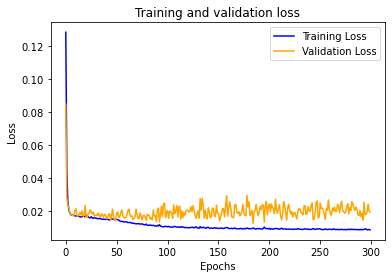

In [8]:
# two different models
loss_epoch = train_model(models, 300) #epoch for 300

#### 2.4 Please include the plot that shows how the training/validation loss vary with the training epoch. Show the plots using the above two models and write down the observation. (5%)
##### Here is the example figure
![train_ex.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW2/img/HW2-2.png?raw=true)

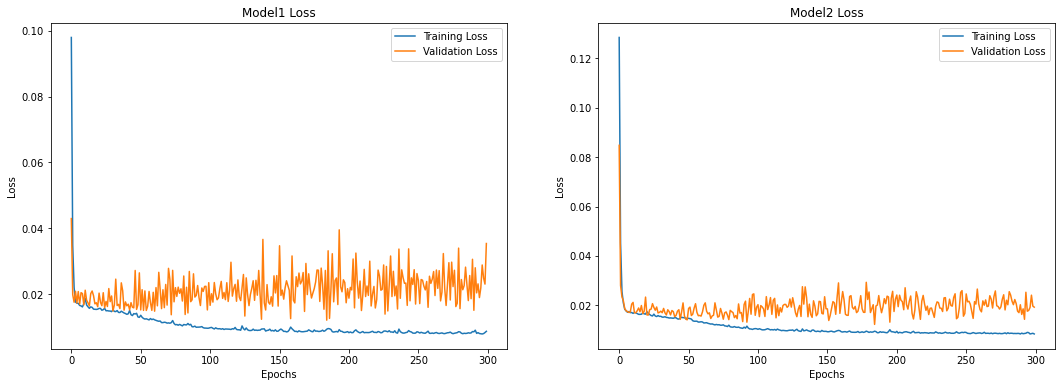

In [9]:
# draw loss curve
def loss_curve(loss_epoch):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    for i, (name, values) in enumerate(models.items()):
        ax[i].plot(loss_epoch[name]["Training Loss"], label='Training Loss')
        ax[i].plot(loss_epoch[name]["Validation Loss"], label='Validation Loss')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Loss')
        ax[i].legend()
        ax[i].set_title(f"{name} Loss") 
    plt.show()
    
loss_curve(loss_epoch)

####  Observation:
Model 1 loss curve的震盪比右邊來的大，另外若training loss的curve一直往下降而validation loss開始往上時，表示模型開始overfit，從圖表可以看到兩個模型到了epoch 45-50，兩條curve非常接近，因此可以在該區間停止訓練模型，在overfit前將模型存取。

#### 2.5 From the observation of the previous question, please determine an appropriate epoch and retrain the two models to avoid overfitting. Also, draw the loss plot of two models and save the last model as ***model1.pth*** and ***model2.pth***. (10%)
##### (Note. You should reload the models and the optimizer, otherwise, you will resume from the previous stop.)

Epoch 1 		 Training Loss: 0.002874158895932711 		 Validation Loss: 0.023498399183154106
Epoch 2 		 Training Loss: 0.0018655408460360307 		 Validation Loss: 0.017146378755569458
Epoch 3 		 Training Loss: 0.0019762301101134373 		 Validation Loss: 0.012834086082875729
Epoch 4 		 Training Loss: 0.001145753006522472 		 Validation Loss: 0.010748269967734814
Epoch 5 		 Training Loss: 0.0011590904771135403 		 Validation Loss: 0.00947992317378521
Epoch 6 		 Training Loss: 0.0023330530295005212 		 Validation Loss: 0.009178703650832176
Epoch 7 		 Training Loss: 0.0011714325071527408 		 Validation Loss: 0.008814962580800056
Epoch 8 		 Training Loss: 0.0013522875423614795 		 Validation Loss: 0.00825959350913763
Epoch 9 		 Training Loss: 0.001328821938771468 		 Validation Loss: 0.00833464041352272
Epoch 10 		 Training Loss: 0.001505260427410786 		 Validation Loss: 0.008875086903572083
Epoch 11 		 Training Loss: 0.0015979124089846243 		 Validation Loss: 0.009240508079528809
Epoch 12 		 Training Loss:

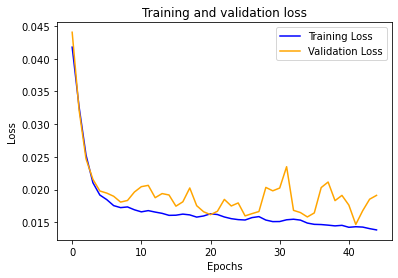

Epoch 1 		 Training Loss: 0.019396261526988104 		 Validation Loss: 0.09685497730970383
Epoch 2 		 Training Loss: 0.002424036940703025 		 Validation Loss: 0.02299981750547886
Epoch 3 		 Training Loss: 0.0022877086527072466 		 Validation Loss: 0.02372760884463787
Epoch 4 		 Training Loss: 0.0016328440262721134 		 Validation Loss: 0.022459153085947037
Epoch 5 		 Training Loss: 0.002071004217633834 		 Validation Loss: 0.018361708149313927
Epoch 6 		 Training Loss: 0.002217999014716882 		 Validation Loss: 0.016828084364533424
Epoch 7 		 Training Loss: 0.0018284936937002034 		 Validation Loss: 0.01549744326621294
Epoch 8 		 Training Loss: 0.0013746473078544324 		 Validation Loss: 0.014955590479075909
Epoch 9 		 Training Loss: 0.0018984477680463057 		 Validation Loss: 0.01386202871799469
Epoch 10 		 Training Loss: 0.0013558322993608622 		 Validation Loss: 0.012570488266646862
Epoch 11 		 Training Loss: 0.0012693511178860297 		 Validation Loss: 0.011829221621155739
Epoch 12 		 Training Loss: 0

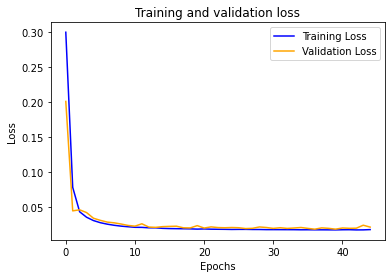

In [10]:
# load the dataset
# train dataloader
path = "./data/train.csv"
train = ConcreteDataset(path)
train_dl = DataLoader(train, batch_size=64, shuffle=True)

# validation dataloader
path = "./data/validation.csv"
validation = ConcreteDataset(path)
validation_dl = DataLoader(validation, batch_size=64, shuffle=False)

# define the model
# model 1
model1 = MLP(8, 256, 64, 8, nn.Tanh(), nn.Tanh()) #inputs are 8 features
# model 2
model2 = MLP(8, 64, 16, 8, nn.Tanh(), nn.Identity())

models = {"Model1":model1,"Model2":model2} #create a dictionary for two models

loss_epoch = train_model(models, 45) #epoch for 45

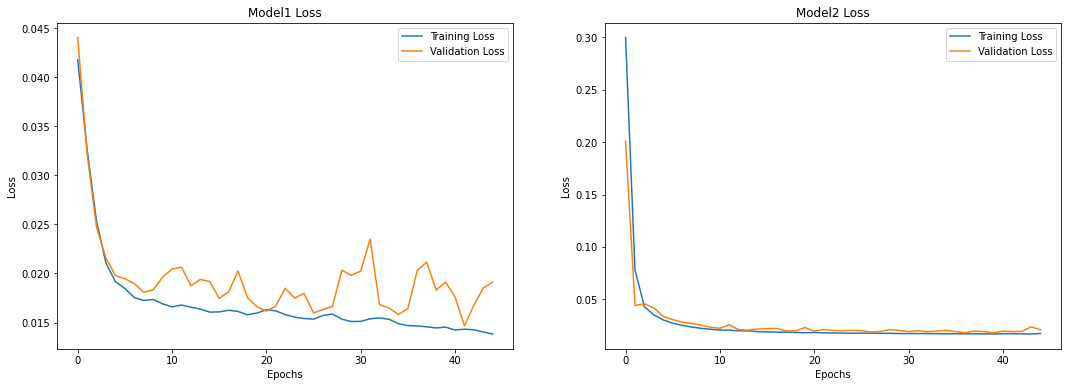

In [11]:
loss_curve(loss_epoch)

####  Observation:
從epoch=45的模型比較，Model1的loss curve明顯比Model2來的不穩定，可能造成的原因為hidden node設太多或是output activation function挑選得不夠好，不適用該題目。

#### 2.6 Please load the checkpoints saved from previous question and calculate the mean squared error on test dataset for two models respectively. Also, make a dataframe with target and prediction like below and save it as ***regression.csv*** (5%)
|Target|Model1|Model2|
|:---:|:---:|:---:|
|24.05|26.35|27.04|
|21.67|32.78|21.95|

In [12]:
# evaluate model
def evaluate(models, test_dl):
    csv = {}
    predictions, actuals = [], []
    
    for name, values in models.items():
        values.load_state_dict(torch.load(f'{name}.pth')) #load the model
        values.eval()
        
        for inputs, labels in test_dl:
            y_pred = values(inputs)
            y_pred = test.scaler.inverse_transform(y_pred.detach().numpy()) # need to transform the scaled data to original
            actual = test.scaler.inverse_transform(labels.detach().numpy())
            mse = mean_squared_error(actual, y_pred)
            print(f'{name} MSE: {mse}')
            actual = actual.reshape((len(actual), 1))
            # store
            predictions.append(y_pred)
            actuals.append(actual)
            csv["Target"] = actual.flatten() #flat the data to 1D
            csv[name] = y_pred.flatten()

    # calculate mse
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) #to see the data 
    
    #save as csv
    pd.DataFrame(csv).to_csv('output.csv', index = False)


In [13]:
path = "./data/test.csv"
test = ConcreteDataset(path)
test_dl = DataLoader(test, shuffle=False, batch_size=len(test))


# define the model
model1 = MLP(8, 256, 64, 8, nn.Tanh(), nn.Tanh()) #inputs are 8 features
model2 = MLP(8, 64, 16, 8, nn.Tanh(), nn.Identity())
models = {"Model1":model1,"Model2":model2} #create a dictionary for two models               
evaluate(models, test_dl) 

Model1 MSE: 133.95997619628906
Model2 MSE: 144.98280334472656


In [14]:
# a dataframe with target and prediction
#load the csv
data = pd.read_csv('output.csv')
data

,Target,Model1,Model2
0,26.060001,26.330263,29.195782
1,10.350000,3.210926,9.495899
2,74.990000,46.866810,41.248970
3,59.000000,44.549652,45.239720
4,52.120000,38.627180,30.937914
...,...,...,...
98,33.400000,26.409422,25.372700
99,39.269997,22.755802,20.163052
100,18.130001,5.321873,8.396001
101,33.010002,19.738813,21.917265
